<a href="https://colab.research.google.com/github/TheRadDani/Sine-Wave-prediction-tflite-model/blob/main/tflite_sinewave_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [2]:
# Settings
nsamples = 10000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

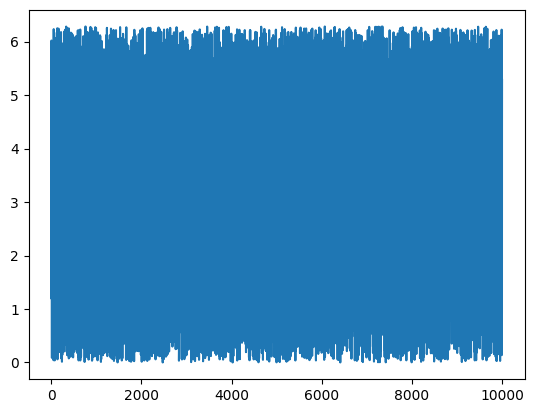

In [3]:
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values);

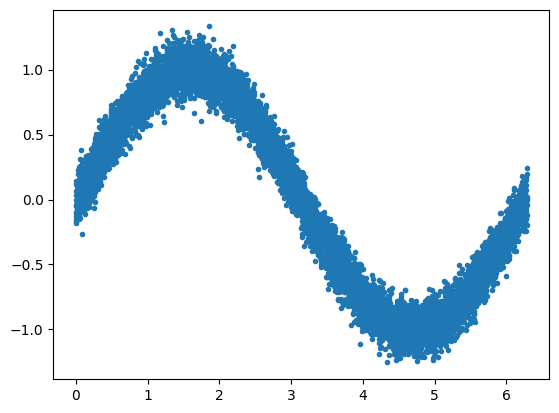

In [4]:

# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')
plt.show();

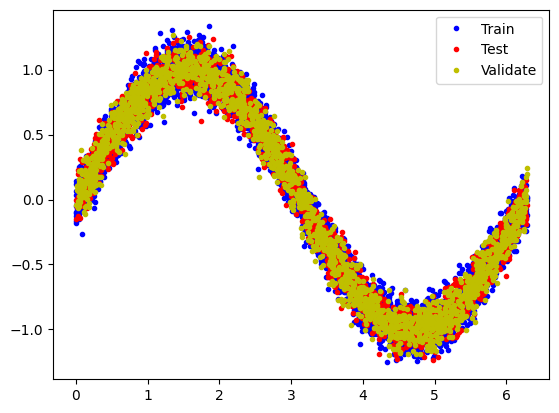

In [5]:

# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [6]:
#@title Model architecture with 3 hidden units
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(1,)),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(18, activation='relu'),
    layers.Dense(1)
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 18)                594       
                                                                 
 dense_3 (Dense)             (None, 1)                 19        
                                                                 
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________
model architecture


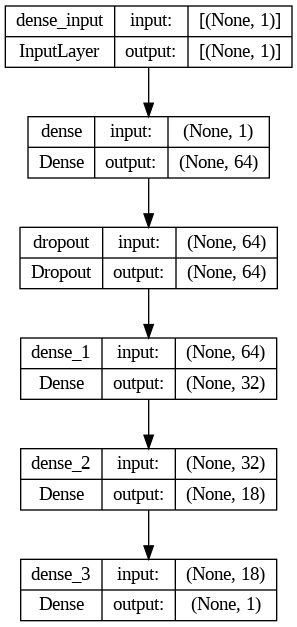

In [7]:
#@title Model architecture
model.summary()
print("model architecture")
plot_model(model, to_file='model.png', show_shapes=True)

In [8]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [9]:
# Train model
batch_size = 32  # try a smaller batch size for better generalization
steps_per_epoch = x_train.shape[0] // batch_size  # set number of steps per epoch based on batch size
validation_steps = x_val.shape[0] // batch_size  # set number of validation steps based on batch size

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)  # stop training when validation loss doesn't improve for 10 epochs
# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.01, min_lr=0.00001)

history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=batch_size,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(x_val, y_val),
                    validation_steps=validation_steps,
                    callbacks = [early_stop,reduce_lr],
                    verbose = 1)

Epoch 1/500
187/187 [==============================] - 3s 10ms/step - loss: 0.4260 - mae: 0.4260 - val_loss: 0.2967 - val_mae: 0.2967 - lr: 0.0010
Epoch 2/500
187/187 [==============================] - 2s 10ms/step - loss: 0.2877 - mae: 0.2877 - val_loss: 0.2301 - val_mae: 0.2301 - lr: 0.0010
Epoch 3/500
187/187 [==============================] - 2s 10ms/step - loss: 0.2247 - mae: 0.2247 - val_loss: 0.1917 - val_mae: 0.1917 - lr: 0.0010
Epoch 4/500
187/187 [==============================] - 2s 13ms/step - loss: 0.1815 - mae: 0.1815 - val_loss: 0.1464 - val_mae: 0.1464 - lr: 0.0010
Epoch 5/500
187/187 [==============================] - 2s 10ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.1207 - val_mae: 0.1207 - lr: 0.0010
Epoch 6/500
187/187 [==============================] - 2s 9ms/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.1102 - val_mae: 0.1102 - lr: 0.0010
Epoch 7/500
187/187 [==============================] - 2s 9ms/step - loss: 0.1260 - mae: 0.1260 - val_loss: 0.0969 - va

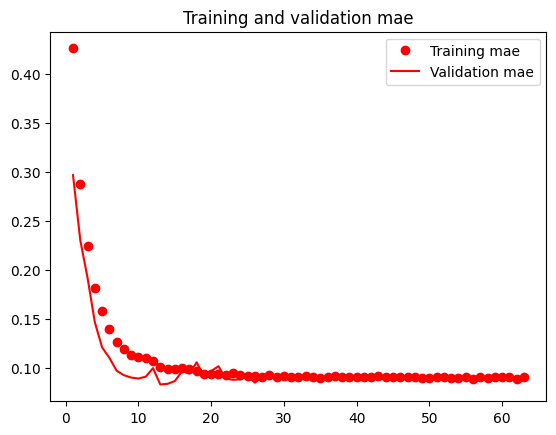

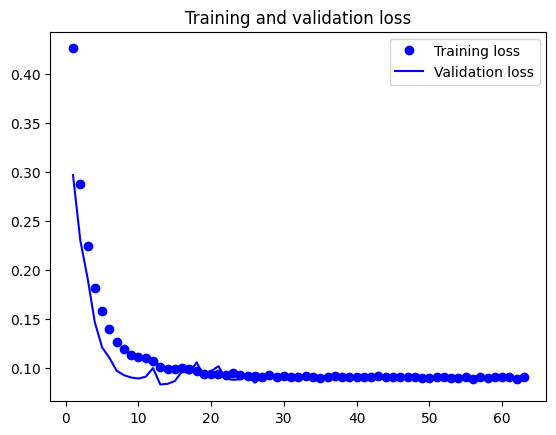

In [10]:
# Plot the training history
loss = history.history['mae']
val_loss = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.title('Training and validation mae')
plt.plot(epochs, loss, 'ro', label='Training mae')
plt.plot(epochs, val_loss, 'r', label='Validation mae')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
#@title Save model
filepath = "./model.h5"
model.save(filepath)

63/63 [==============================] - 0s 2ms/step


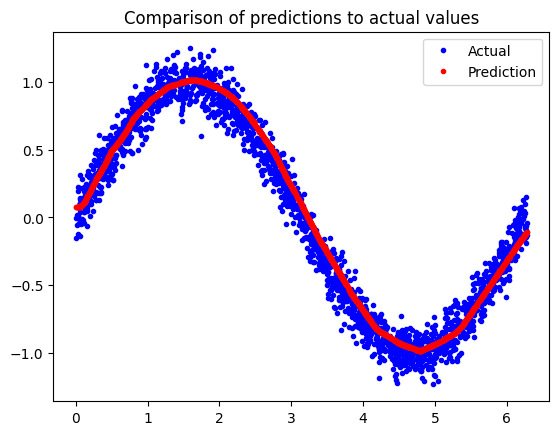

In [12]:
#@title Plot predictions against actual values

#load model for inference
inference_model = tf.keras.models.load_model(filepath)
keras_predictions = inference_model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, keras_predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

## .h5 model to ONNX conversion

To demostrate how to convert a Keras model to ONNX format, load the ONNX model with onnxruntime, convert the ONNX model to PyTorch format, and run inference with PyTorch on some example input data. The example Keras model is assumed to be saved as an .h5 file.

## Setup
Before proceeding with the conversion and inference, we need to install the necessary libraries. We use pip to install onnx, onnxruntime, and onnx2keras. Additionally, we import numpy, torch, and torchvision.transforms for use later in the notebook.

## Model Conversion
To convert the Keras model to ONNX format, we use the onnx2keras library to load the Keras model and convert it to an ONNX model. The resulting ONNX model is then saved as a .onnx file. We then load the ONNX model with onnxruntime and prepare the input tensor shape.

## Inference
We generate some example input data and run inference with onnxruntime. The output is then converted to PyTorch format, and we prepare the input tensor for PyTorch. Finally, we run inference with the PyTorch model and print the outputs.

In [13]:
# First, install the necessary libraries
!pip install onnx onnxruntime tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


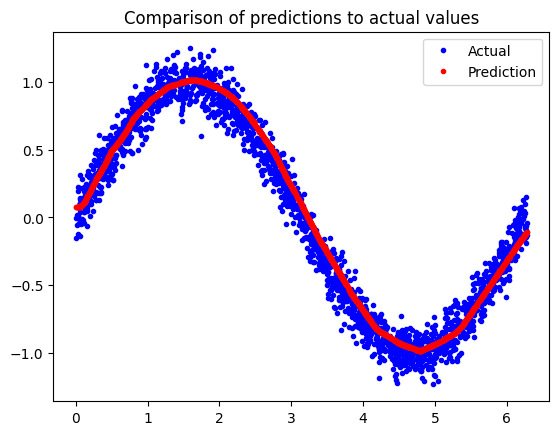

PyTorch outputs:
 [[-0.75489634]
 [-0.9203815 ]
 [-0.8143943 ]
 ...
 [-0.43966195]
 [ 0.43755722]
 [ 0.4906057 ]]
Keras outputs:
 [[-0.75489634]
 [-0.9203814 ]
 [-0.81439435]
 ...
 [-0.43966198]
 [ 0.4375572 ]
 [ 0.4906057 ]]


In [14]:
import onnx
import onnxruntime as ort
import torch
import numpy as np
import tf2onnx



# Convert the Keras model to ONNX format

onnx_model, _ = tf2onnx.convert.from_keras(inference_model)

# Load the ONNX model using the ONNX runtime
ort_session = ort.InferenceSession(onnx_model.SerializeToString())

# Define a PyTorch model class that matches the ONNX model inputs and outputs
class PyTorchModel(torch.nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.input_name = ort_session.get_inputs()[0].name
        self.output_name = ort_session.get_outputs()[0].name

    def forward(self, inputs):
        outputs = ort_session.run([self.output_name], {self.input_name: inputs.numpy()})[0]
        return torch.from_numpy(outputs)

# Instantiate the PyTorch model
pytorch_model = PyTorchModel()


# Test the PyTorch model
input_data = x_test[...,np.newaxis].astype(np.float32).copy()
inputs = torch.from_numpy(input_data)

pytorch_predictions = pytorch_model(inputs)


plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, pytorch_predictions.numpy(), 'r.', label='Prediction')
plt.legend()
plt.show()

# Print the outputs
print("PyTorch outputs:\n", pytorch_predictions.numpy())
print("Keras outputs:\n", keras_predictions)

To compute the level of similarity between the PyTorch and Keras predictions, you can use a similarity metric such as mean squared error (MSE) or cosine similarity.

In [15]:
# Compute the mean squared error between the PyTorch and Keras predictions
mse = np.mean(np.square(pytorch_predictions.numpy() - keras_predictions))
print("Mean squared error:", mse)

Mean squared error: 4.3430225e-15


In [16]:
#@title Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

7512

In [17]:
#@title Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [20]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))